In [ ]:
!git clone https://github.com/Oliverluyu/brain_tumor_img_segmentation.git
%cd brain_tumor_img_segmentation
!git checkout experiment2


Cloning into 'brain_tumor_img_segmentation'...
remote: Enumerating objects: 13164, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 13164 (delta 3), reused 10 (delta 3), pack-reused 13149
Receiving objects: 100% (13164/13164), 505.57 MiB | 18.43 MiB/s, done.
Resolving deltas: 100% (557/557), done.
Updating files: 100% (15653/15653), done.
/content/brain_tumor_img_segmentation
Branch 'experiment2' set up to track remote branch 'experiment2' from 'origin'.
Switched to a new branch 'experiment2'


# Transfer learning from about classifaction model

ongoing: need to add accuracy, add Segmentation Metrics
https://github.com/hsiangyuzhao/Segmentation-Metrics-PyTorch/blob/master/readme.md


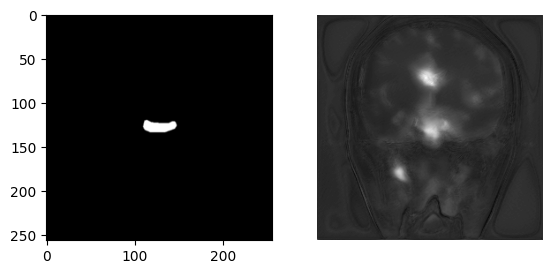

Epoch 1/1, Training Loss: 0.0031, Validation Loss: 0.0095


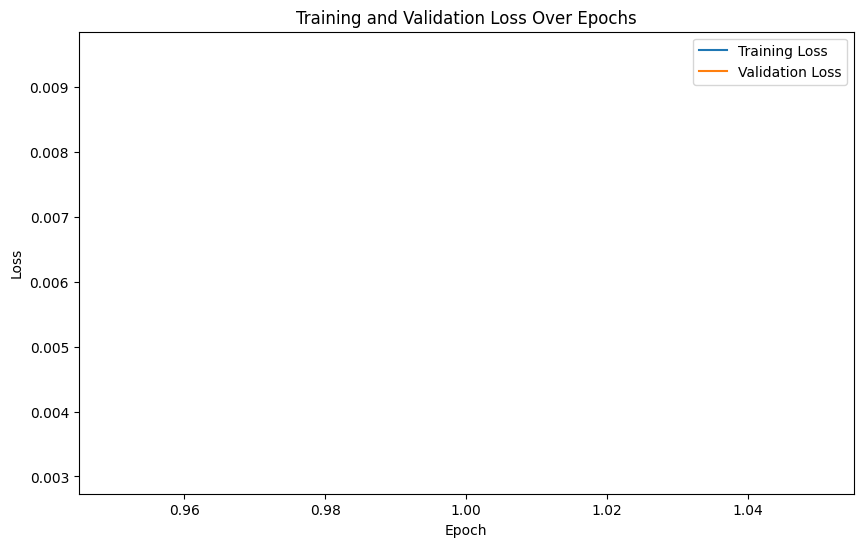

Mean accuracy on training data: 394.47%
{'pixel_accuracy': 1.0, 'dice': nan, 'precision': nan, 'recall': nan, 'specificity': 1.0}


KeyboardInterrupt: 

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from models.network_helper import init_weights
import torchvision.transforms as transforms
import torch.optim as optim
from models.VanillaUnet import unet_2D
import matplotlib.pyplot as plt
import platform


class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_dir = os.path.join(root_dir, 'images')
        self.mask_dir = os.path.join(root_dir, 'masks')
        self.image_paths = self._get_paths(self.image_dir)
        self.mask_paths = self._get_paths(self.mask_dir)

    def _get_paths(self, directory):
        paths = []
        for subdir in os.listdir(directory):
            subdir_path = os.path.join(directory, subdir)
            if os.path.isdir(subdir_path):
                for filename in os.listdir(subdir_path):
                    paths.append(os.path.join(subdir_path, filename))
        return paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        # image = Image.open(img_path).convert('L')  # Keep as grayscale
        # mask = Image.open(mask_path).convert('L')  # Keep as grayscale
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask


# Define transforms
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Initialize dataset and dataloaders
train_dataset = BrainTumorDataset(root_dir='datasets/segmentation/train',
                                  transform=transform)
test_dataset = BrainTumorDataset(root_dir='datasets/segmentation/test',
                                 transform=transform)
val_dataset = BrainTumorDataset(root_dir='datasets/segmentation/validation',
                                transform=transform)

# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Define VanillaUnet model for segmentation
model = unet_2D(in_channels=1, mode='segmentation')  # Assuming segmentation task setup

# Load the pretrained classification model
classification_model_path = 'classification_model.pth'
model.load_state_dict(torch.load(classification_model_path))

# Adjust the model for segmentation if necessary
# This step might be redundant if the model is already initialized for segmentation
model.mode = 'segmentation'

# Freeze the encoder weights
model.freeze_encoder()

# Proceed with the setup for training, such as defining loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

training_losses = []
validation_losses = []

# Training loop
num_epochs = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        images, masks = batch
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        # image_plot = masks[0,0].numpy()  # Assuming images are grayscale
        # plt.subplot(1, 2, 1)  # Adjust subplot layout for multiple images
        # plt.imshow(image_plot, cmap='gray')
        # image_plot = outputs[0,0].detach().numpy()  # Assuming images are grayscale
        # plt.subplot(1, 2, 2)  # Adjust subplot layout for multiple images
        # plt.imshow(image_plot, cmap='gray')
        # plt.axis('off')
        # plt.show()
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # print(loss.item() ,running_loss)

    epoch_loss = running_loss / len(train_dataset)

    # Validation
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            images, masks = batch
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, masks)
            val_running_loss += val_loss.item() * images.size(0)

            image_plot1 = masks[0,0].cpu().numpy()   # Assuming images are grayscale
            image_plot2 = outputs[0,0].detach().cpu().numpy() # Assuming images are grayscale
        plt.subplot(1, 2, 1)  # Adjust subplot layout for multiple images
        plt.imshow(image_plot1, cmap='gray')
        plt.subplot(1, 2, 2)  # Adjust subplot layout for multiple images
        plt.imshow(image_plot2, cmap='gray')
        plt.axis('off')
        plt.show()
    val_epoch_loss = val_running_loss / len(val_dataset)

    training_losses.append(epoch_loss)
    validation_losses.append(val_epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}")

# After the training loop, plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


def calculate_pixel_accuracy(predicted, true):
    """Calculate pixel-wise accuracy."""
    correct = torch.eq(predicted, true).sum().item()  # Count correct pixels
    total = torch.numel(predicted)  # Total number of pixels
    return correct / total

# Switch model to evaluation mode
model.eval()

# Track accuracy
accuracies = []

with torch.no_grad():
    for images, masks in train_loader:  # Use your training DataLoader
        images, masks = images.to(device), masks.to(device)

        # Predict segmentation masks
        outputs = model(images)

        # Assuming your model outputs raw logits, you'd typically apply a threshold or argmax
        # For simplicity, let's say your model's output is already binary or categorical
        predicted_masks = torch.argmax(outputs, dim=1)  # Use argmax for categorical masks

        # Calculate accuracy for the current batch and store
        acc = calculate_pixel_accuracy(predicted_masks, masks)
        accuracies.append(acc)

# Calculate mean accuracy across all batches
mean_accuracy = sum(accuracies) / len(accuracies)
print(f"Mean accuracy on training data: {mean_accuracy * 100:.2f}%")


def calculate_metrics(pred, target, num_classes=2, ignore_background=True):
    """
    Calculate segmentation metrics.
    Args:
    - pred (torch.Tensor): Predicted segmentation map, shape (N, H, W)
    - target (torch.Tensor): Ground truth segmentation map, shape (N, H, W)
    - num_classes (int): Number of classes in the segmentation task
    - ignore_background (bool): If True, ignore metrics for the background class (assumed to be 0)
    Returns:
    - metrics (dict): Dictionary containing pixel accuracy, Dice, precision, recall, and specificity
    """
    # Initialize confusion matrix
    conf_matrix = torch.zeros(num_classes, num_classes)
    for t, p in zip(target.view(-1), pred.view(-1)):
        conf_matrix[t.long(), p.long()] += 1

    # Ignore background class if needed
    start_index = 1 if ignore_background else 0

    # Initialize metrics
    metrics = {
        'pixel_accuracy': 0,
        'dice': [],
        'precision': [],
        'recall': [],
        'specificity': []
    }

    # Calculate metrics per class
    for i in range(start_index, num_classes):
        TP = conf_matrix[i, i]
        FP = conf_matrix[:, i].sum() - TP
        FN = conf_matrix[i, :].sum() - TP
        TN = conf_matrix.sum() - (TP + FP + FN)

        pixel_accuracy = (TP + TN) / conf_matrix.sum()
        dice = (2 * TP) / (2 * TP + FP + FN)
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        specificity = TN / (TN + FP)

        metrics['dice'].append(dice.item())
        metrics['precision'].append(precision.item())
        metrics['recall'].append(recall.item())
        metrics['specificity'].append(specificity.item())

    metrics['pixel_accuracy'] = pixel_accuracy.item()
    metrics['dice'] = sum(metrics['dice']) / len(metrics['dice'])
    metrics['precision'] = sum(metrics['precision']) / len(metrics['precision'])
    metrics['recall'] = sum(metrics['recall']) / len(metrics['recall'])
    metrics['specificity'] = sum(metrics['specificity']) / len(metrics['specificity'])

    return metrics

# Example usage
with torch.no_grad():
    for images, masks in test_loader:  # Assuming test_loader is your DataLoader
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        metrics = calculate_metrics(preds, masks, num_classes=2)  # Adjust num_classes accordingly

        print(metrics)


